In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
clist = ['#c21f30', '#ffffff', '#1677b3']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)
new_cmap = ListedColormap(clist)

plt.style.use('default')
sns.set_color_codes()

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.cal'] = 'Arial'
rcParams['mathtext.it'] = 'Arial'
rcParams['mathtext.rm'] = 'Arial'

[2.47028517e-02 2.24679455e+00 1.10757533e+03]


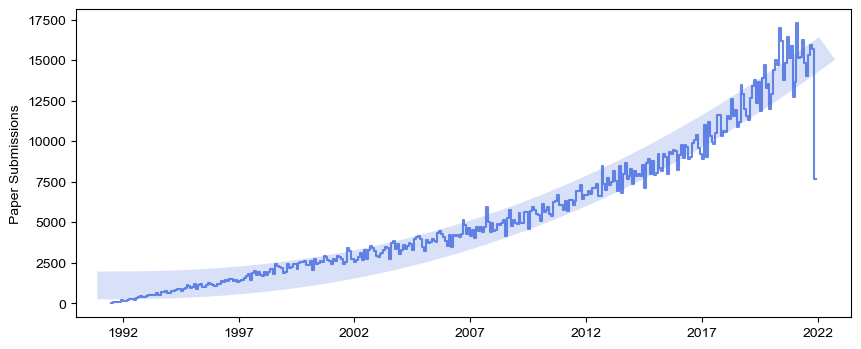

In [2]:
def x2_func(x, a, b, c):
    return a * x** b + c

data = pd.read_csv('get_monthly_submissions.csv')
popt, pcov = curve_fit(x2_func, np.arange(len(data))[:-1], data.submissions[:-1])

plt.figure(figsize=(10, 4))
plt.step(np.arange(len(data)), data.submissions, color='royalblue', alpha=0.8)
plt.plot(np.arange(len(data)), x2_func(np.arange(len(data)), *popt), color='royalblue', lw=20, alpha=0.2)
print(popt)
# plt.yscale('log')
plt.xticks(6 + 12*np.arange(0, 35, 5), 1992+np.arange(0, 35, 5))
plt.ylabel('Paper Submissions')
path = 'arXivCount-{:.2f}-{}.png'.format(popt[1], '1991714')
# plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

In [3]:
import os, re
g = os.walk('../')

markdown_path = []
for path, _, file_list in g:
    for file_name in file_list:
        if file_name.startswith('AstroPH'):
            markdown_path = np.append(markdown_path, os.path.join(path, file_name))
markdown_path = [re.sub(r'\\+', '/', i) for i in markdown_path]

In [4]:
data_list = []
for md in markdown_path:
    print(md)
    with open(md, 'r', encoding='utf-8') as f:
        data = f.read()
    data = [i for i in data.split('## 20') if i.startswith('2')]
    for d in range(len(data)):
        if re.match(r'^\d{2}-\d{2}-\d{2}\s+$', data[d]):
            continue
        date = '20' + re.search(r'(\d{2}-\d{2}-\d{2})', data[d]).group(1)
        title = re.findall(r'\s+\d\.\s+\[(.+)\]', data[d])
        arxiv = re.findall(r'\d\.\s+\[.+\]\(h{1,2}ttps.+/(.+)\)', data[d])
        kw_content = re.split(r'\s+\d\.\s+\[.+\]\(.+\)\s+', data[d])[1:]
        keyword, content = [], []
        for kc in kw_content:
            kw = re.search(r'^>\s+([A-Za-z0-9_ \,]+)', kc)
            if kw: 
                keyword.append(kw.group(1))
                content.append(re.search(r'^>\s+[A-Za-z0-9_ \,]+\s+(.+)\s*', kc).group(1))
            else:
                keyword.append('')
                content.append(kc)
        if len(title) == len(arxiv) == len(content) == 0:
            title, arxiv, keyword, content = [''], [''], [''], [re.search(r'\d{2}-\d{2}-\d{2}\s+(.+)\s+', data[d]).group(1)]
        data_format = pd.DataFrame({
            'month': re.search(r'(\d{4}-\d{2})', date).group(1),
            'date': date,
            'arxiv': arxiv,
            'title': title,
            'keyword': keyword,
            'content': content
        }, columns=['month', 'date', 'arxiv', 'title', 'keyword', 'content'])
        data_list.append(data_format)

../2020/12/AstroPH-2020-12.md
../2021/01/AstroPH-2021-01.md
../2021/02/AstroPH-2021-02.md
../2021/03/AstroPH-2021-03.md
../2021/04/AstroPH-2021-04.md
../2021/05/AstroPH-2021-05.md
../2021/06/AstroPH-2021-06.md
../2021/07/AstroPH-2021-07.md
../2021/08/AstroPH-2021-08.md
../2021/09/AstroPH-2021-09.md
../2021/10/AstroPH-2021-10.md
../2021/11/AstroPH-2021-11.md
../2021/12/AstroPH-2021-12.md
../2022/01/AstroPH-2022-01.md


In [5]:
data = pd.concat(data_list)
noupdate = data.loc[data.content.str.contains('停更')]
data = data.loc[~data.content.str.contains('停更')]
data = data.reset_index(drop=True)

In [6]:
count_data = pd.DataFrame({'Month': data.drop_duplicates('date').groupby('month').count().date.index.values,
                           'Days': data.drop_duplicates('date').groupby('month').count().date.values,
                           'Count': data.groupby('month').count().loc[:, 'title'].values})
count_data.loc[:, 'Rate'] = count_data.loc[:, 'Count'] / count_data.loc[:, 'Days']

In [7]:
count_data.loc[:, 'Days'].sum(), noupdate

(273,
      month        date arxiv title keyword content
 0  2020-12  2020-12-28                      圣诞节停更。
 0  2021-10  2021-10-21                       今天停更。
 0  2021-11  2021-11-26                      感恩节停更。
 0  2021-12  2021-12-27                      圣诞节停更。
 0  2021-12  2021-12-29                       元旦停更。
 0  2021-12  2021-12-31                      今天也停更。)

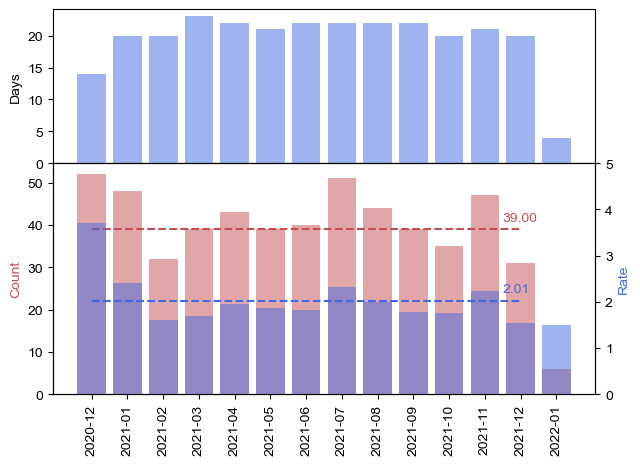

In [8]:
from matplotlib import gridspec
plt.figure(figsize=(7, 5))
plt.subplots_adjust(wspace=0, hspace=0)
gs = gridspec.GridSpec(5, 1)

plt.subplot(gs[0:2, :])
plt.bar(data.drop_duplicates('date').groupby('month').count().date.index.values, 
        data.drop_duplicates('date').groupby('month').count().date.values, color='royalblue', alpha=0.5)
plt.ylabel('Days')
# plt.xticks([])

ax = plt.subplot(gs[2:, :])
plt.bar(data.groupby('month').count().loc[:, 'title'].index.values, 
        data.groupby('month').count().loc[:, 'title'].values, color='r', alpha=0.5)
plt.xticks(data.groupby('month').count().loc[:, 'title'].index.values,
           data.groupby('month').count().loc[:, 'title'].index.values, rotation=90)
plt.hlines(count_data.Count.mean(), 0, 12, ls='--', color='r')
plt.text(11.5, count_data.Count.mean()*1.05, '{:.2f}'.format(count_data.Count.mean()), color='r')
plt.ylabel('Count', color='r')

ax = ax.twinx()
ax.bar(data.groupby('month').count().loc[:, 'title'].index.values, 
        data.groupby('month').count().loc[:, 'title'].values / data.drop_duplicates('date').groupby('month').count().date.values, 
        color='royalblue', alpha=0.5)
ax.set_ylim(0, 5)
plt.ylabel('Rate', color='royalblue')
plt.hlines(count_data.Rate.mean(), 0, 12, ls='--', color='royalblue')
plt.text(11.5, count_data.Rate.mean()*1.1, '{:.2f}'.format(count_data.Rate.mean()), color='royalblue')
# plt.savefig('ReadCount.png', dpi=300, bbox_inches='tight')
plt.show()

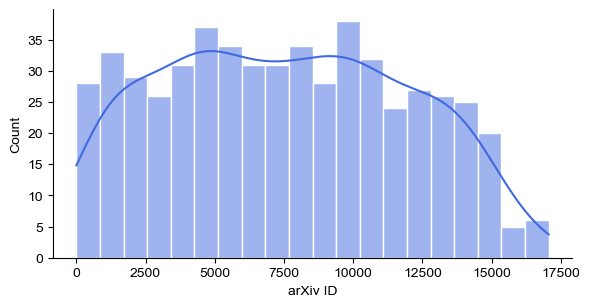

In [9]:
asd = data.loc[data.arxiv.str.contains(r'\d{4}\.\d{4,5}')].arxiv.str.split('.', expand=True).loc[:, 1].apply(int).values
sns.displot(asd, kde=True, bins=20, color='royalblue', edgecolor='white', height=3, aspect=8/4)
plt.xlabel('arXiv ID')
# plt.savefig('arXivID.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
import pkuseg, pprint
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

string_all, string_list = '', []
for i in range(len(data)):
    string = data.content[i]
    string = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?', '', string)
    string = re.sub(r'\<img.+?\>', '', string)
    string = re.sub(r'\<p.+?\>', '', string)
    string = re.sub(r'\</p\>', '', string)
    string = re.sub(r'`(.+?)`', '\g<1>', string)
    string = re.sub(r'\${1,2}.+?\${1,2}', '', re.sub(r'\n', '', string))
    string_list.append(string)
    string_all += string + '\n'
#    print(re.sub(r'\[(.+?)\]\(.+?\)', '\g<1>', string))
#    print('###################')

seg = pkuseg.pkuseg(user_dict='dict.txt', postag=True)
text = seg.cut(string_all)
with open('stop_words.txt', encoding='utf-8') as f:
    stopwords = f.read()
new_text = []
for w in text:
    if w[0] not in stopwords:
        if 'n' in w[1]:
            new_text.append(w[0])
counter = Counter(new_text)
# pprint.pprint(counter.most_common(100))

In [ ]:
# rcParams['font.sans-serif'] = [''] # 指定默认字体
# rcParams['axes.unicode_minus'] = False

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y+1, value, ha="center", color='gray', size=8) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left", rotation=90)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

keywds = [i[0] for i in counter.most_common(50)]
height = [i[1] for i in counter.most_common(50)]
plt.figure(figsize=(10, 4))
p = sns.barplot(keywds, height, palette='RdYlBu')
show_values(p)

from matplotlib.font_manager import FontProperties
font = FontProperties(fname='C:/Windows/Fonts/simhei.ttf', size=9)
plt.xticks(rotation=90, fontproperties=font)
# plt.ylim(0, 125)
# plt.savefig('ContentKeyCount', dpi=300, bbox_inches='tight')
plt.show()

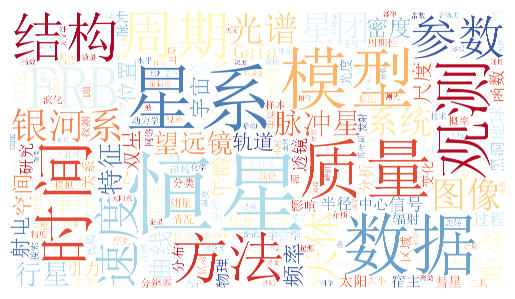

In [12]:
wordcloud = WordCloud(
    font_path = 'simsun.ttc',
    background_color = 'white',
    prefer_horizontal = 0.7,
    width = 1920,
    height = 1080,
    scale = 10,
    margin = 2,
    colormap = 'RdYlBu' # 'Spectral'
).generate_from_frequencies(counter)

# wordcloud.to_file('content-4.png')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
words_max = counter.most_common(50)
np.random.shuffle(words_max)
nodes, links = [], []
for i in range(len(words_max)):
    nodes.append({
        'id': i,
        'name': words_max[i][0],
        'symbolSize': (words_max[i][1] - 34) *((66-5) / (247-34)) + 5
    })
    for j in range(i+1, len(words_max)):
#        print(words_max[i], words_max[j])
        for k in string_list:
            if (words_max[i][0] in k) and (words_max[j][0] in k):
                links.append({
                    'source': str(i),
                    'target': str(j)
                })
                break
                
from pyecharts import options as opts
from pyecharts.charts import Graph
from pyecharts.globals import ThemeType

c = (
    Graph(init_opts=opts.InitOpts(width="1920px", height="1080px", theme=ThemeType.VINTAGE))
    .add(
        "",
        nodes=nodes,
        links=links,
        layout="circular",
        is_rotate_label=True,
        linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
        label_opts=opts.LabelOpts(position="right"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title=""),
        legend_opts=opts.LegendOpts(orient="vertical", pos_left="2%", pos_top="20%"),
    )
    .render("content.html")
)

In [16]:
import pkuseg, pprint
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

title_string = '\n'.join(data.title.values).lower()
title_string = re.sub(r'fast radio bursts', 'fast radio burst', title_string)
title_string = re.sub(r'fast radio burst', 'fast_radio_bursts', title_string)
title_string = re.sub(r'milky way', 'milky_way', title_string)
title_string = re.sub(r'frbs', 'frb', title_string)
title_string = re.sub(r'frb', 'fast_radio_bursts', title_string)
title_string = re.sub(r'stars', 'star', title_string)
title_string = re.sub(r'clusters', 'cluster', title_string)

seg = pkuseg.pkuseg(user_dict='dict.txt', postag=True)
text = seg.cut(title_string)
with open('english.txt', encoding='utf-8') as f:
    stopwords = f.read()
new_text = []
for w in text:
    if w[0] not in stopwords:
#        if 'n' in w[1]:
            new_text.append(w[0])
new_text = [re.sub('fast_radio_bursts', 'fast radio bursts', i) for i in new_text]
new_text = [re.sub('milky_way', 'milky way', i).capitalize() for i in new_text]
counter = Counter(new_text)

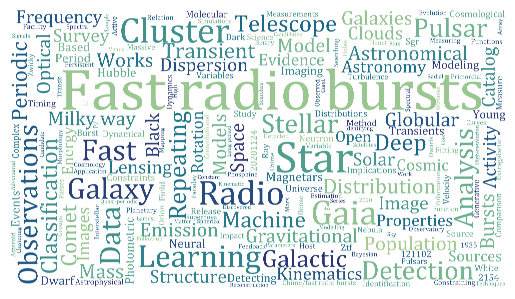

In [17]:
wordcloud = WordCloud(
    font_path = 'cambria.ttc',
    background_color = 'white',
    prefer_horizontal = 0.7,
    width = 1920,
    height = 1080,
    scale = 10,
    margin = 2,
    stopwords = stopwords,
    colormap = 'crest'
).generate_from_frequencies(counter)

# wordcloud.to_file('content-2.png')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
words_max = counter.most_common(50)
np.random.shuffle(words_max)

title_list = re.sub('fast_radio_bursts', 'fast radio bursts', title_string)
title_list = re.sub('milky_way', 'milky way', title_list)
title_list = title_list.split('\n')

nodes, links = [], []
for i in range(len(words_max)):
    nodes.append({
        'id': i,
        'name': words_max[i][0],
        'symbolSize': (words_max[i][1] - 9) *((66-5) / (115-9)) + 5
    })
    for j in range(i+1, len(words_max)):
        for k in title_list:
            if (words_max[i][0].lower() in k) and (words_max[j][0].lower() in k):
                links.append({
                    'source': str(i),
                    'target': str(j)
                })
                break

from pyecharts import options as opts
from pyecharts.charts import Graph
from pyecharts.globals import ThemeType

c = (
    Graph(init_opts=opts.InitOpts(width="1920px", height="1080px", theme=ThemeType.VINTAGE))
    .add(
        "",
        nodes=nodes,
        links=links,
        layout="circular",
        is_rotate_label=True,
        linestyle_opts=opts.LineStyleOpts(color="source", curve=0.3),
        label_opts=opts.LabelOpts(position="right"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title=""),
        legend_opts=opts.LegendOpts(orient="vertical", pos_left="2%", pos_top="20%"),
    )
    .render("title.html")
)

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y+1, value, ha="center", color='gray', size=8) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left", rotation=90)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

keywds = [i[0] for i in counter.most_common(50)]
height = [i[1] for i in counter.most_common(50)]
plt.figure(figsize=(10, 4))
p = sns.barplot(keywds, height, palette='RdYlBu')
show_values(p)
plt.xticks(rotation=90)
plt.ylim(0, 125)
# plt.savefig('TitleKeyCount', dpi=300, bbox_inches='tight')
plt.show()